# Statistical Analysis <a id='stats'></a>

In [73]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib  # load the beta maps in python
from nilearn import plotting  # plot nifti images
from bct import nbs
from scipy.io import savemat
from mne.viz import plot_connectivity_circle

sns.set_palette('Set1')

In [2]:
data_dir = '/Volumes/psybrain/ADM/derivatives'
results_dir = '/Volumes/schnyer/Megan/adm_mem-fc/analysis/stats/'
nibs_dir='/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries'

tasks = ['MemMatch1', 'MemMatch2', 'MemMatch3']
trial_types = ['cue', 'match', 'mismatch']

atlas_file='/Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz'
atlas_lut='/Volumes/psybrain/ADM/derivatives/nibs/power264_labels.tsv'

In [348]:
import re

hc = pd.read_csv('/Volumes/schnyer/Megan/adm_mem-fc/hc_dmn_fpn.csv')
hc['subject'] = hc['subject'].astype(str)

q_global = pd.read_csv('/Volumes/psybrain/ADM/derivatives/nibs/results/modularity_global_mean.csv')
q_global['subject'] = q_global['subject'].astype(str)
q_global['q_global'] = q_global[[col for col in q_global.columns if 'mod_global' in col]].mean(axis=1, skipna=True)

pc_global = pd.read_csv('/Volumes/psybrain/ADM/derivatives/nibs/results/pc_global_mean.csv')
pc_global['subject'] = pc_global['subject'].astype(str)
pc_global['pc_global'] = pc_global[[col for col in pc_global.columns if 'pc_global' in col]].mean(axis=1, skipna=True)

edgesdf = pd.read_csv('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/edgesdf.csv')
edgesdf['subject'] = edgesdf['subject'].astype(str)

df0 = pd.read_csv('/Volumes/schnyer/Megan/adm_mem-fc/data/dataset_2021-11-10.csv')
df0['subject'] = df0['subject'].astype(str)

df = pd.merge(hc, q_global, on='subject', how='outer')
df = pd.merge(df, pc_global, on='subject', how='outer')
df = pd.merge(df, edgesdf, on='subject', how='outer')
df = pd.merge(df, df0, on='subject', how='outer')

df = df.dropna(subset=['hc_dmn_fc']).drop(['edge_0', 'edge_1', 'edge_2', 'edge_3'], axis=1)
df['Group'] = np.where(df['subject'].astype(int) > 40000, "Older Adults", "Young Adults")
df = df.set_index('subject')
df['acc_mean_learning_log'] = np.log10(df['acc_mean_learning'])
df

,hc_dmn_fc,hc_fpn_fc,dmn_fpn_fc,dmn_fc,fpn_fc,mod_global_10,mod_global_12,mod_global_14,mod_global_16,mod_global_18,...,pc_dmn_fpn_12,pc_dmn_fpn_14,pc_dmn_fpn_16,pc_dmn_fpn_18,pc_dmn_fpn_20,pc_dmn_fpn_mean,pc_dmn_mean,pc_fpn_mean,acc_mean_test_log,acc_mean_learning_log
subject,,,,,,,,,,,,,,,,,,,,,
30004,0.246789,0.065381,0.172766,0.329363,0.480001,0.444238,0.420693,0.408654,0.385765,0.367548,...,0.150129,0.175267,0.189694,0.205587,0.218853,0.178769,0.585333,0.755358,-0.028171,-0.037789
30008,0.460457,0.254719,0.275094,0.418964,0.495840,0.528734,0.502317,0.474441,0.452302,0.429773,...,0.179114,0.194050,0.203449,0.206955,0.218107,0.194311,0.586016,0.720762,-0.057158,-0.024824
30009,0.130394,0.029481,0.099538,0.228084,0.435712,0.413678,0.391237,0.365807,0.345061,0.327857,...,0.170291,0.195783,0.203531,0.211377,0.222053,0.192073,0.482981,0.814453,-0.028171,-0.012234
30015,-0.016112,-0.156934,0.079484,0.230274,0.300856,0.389794,0.361667,0.340291,0.319213,0.309240,...,0.215331,0.236555,0.252904,0.261610,0.277564,0.237269,0.651844,0.738657,-0.117783,-0.012234
30019,0.048041,-0.003531,0.186824,0.230634,0.389143,0.393851,0.374114,0.363323,0.339624,0.324801,...,0.290491,0.304593,0.312835,0.318376,0.331827,0.302502,0.715599,0.830522,-0.057158,0.000000
30020,-0.032265,-0.052022,0.413680,0.499089,0.546660,0.459512,0.443905,0.431006,0.417610,0.404618,...,0.198443,0.212673,0.219212,0.234516,0.238569,0.214476,0.690589,0.742340,-0.251314,-0.064941
30023,0.261657,0.197951,0.290672,0.364596,0.435711,0.414433,0.397927,0.374402,0.363748,0.352358,...,0.227489,0.246323,0.251347,0.259999,0.278324,0.243712,0.608987,0.779721,-0.057158,0.000000
30040,0.242890,0.299594,0.197774,0.216430,0.387534,0.415516,0.397027,0.363729,0.357138,0.342851,...,0.280670,0.294189,0.314133,0.324340,0.327024,0.299483,0.685136,0.810084,-0.028171,-0.037789
30057,0.285181,-0.029561,0.213210,0.326095,0.381124,0.486218,0.457946,0.439172,0.420143,0.398985,...,0.253445,0.256582,0.274776,0.287274,0.293760,0.264605,0.610554,0.768614,0.000000,0.000000


In [349]:
from scipy.stats.mstats import zscore

print(df.shape)
df = df[(df['acc_mean_learning'] > 0.33) & (df['acc_mean_test'] > 0.55)]
print(df.shape)

edge_cols = [col for col in df if col.startswith('net')]

regdf = df[['Group', 'sex', 'age', 'actamp', 'actphi', 'pc_global', 'mod_mean', 'pc_dmn_mean', 'pc_fpn_mean', 'hc_dmn_fc', 'hc_fpn_fc', 'dmn_fpn_fc', 'dmn_fc', 'fpn_fc', 'q_global', 'acc_mean_test_log', 'rt_c_mean_test', 'acc_mean_learning_log', 'rt_c_mean_learning'] + edge_cols]

convert_dict = {'Group': str,
                'sex': str,
                'age': str
               }
  
regdf = regdf.astype(convert_dict)

regdf = regdf.select_dtypes(include=object).dropna().join(regdf.select_dtypes(include=[np.number]).dropna().apply(stats.zscore))
regdf.dropna(subset=['sex'])

print(regdf.shape)

(88, 806)
(76, 806)
(76, 29)


In [350]:
df.groupby(['Group', 'sex'])['age', 'hc_dmn_fc', 'hc_fpn_fc', 'q_global'].describe()

age                                                 \
                    count       mean       std   min    25%   50%    75%   
Group        sex                                                           
Older Adults Female  26.0  66.269231  4.477121  60.0  63.00  66.0  69.75   
             Male     2.0  65.000000  1.414214  64.0  64.50  65.0  65.50   
Young Adults Female  28.0  21.535714  3.815001  18.0  18.75  20.0  23.25   
             Male    15.0  20.466667  3.377799  18.0  18.50  19.0  20.00   

                          hc_dmn_fc            ... hc_fpn_fc            \
                      max     count      mean  ...       75%       max   
Group        sex                               ...                       
Older Adults Female  76.0      26.0  0.228200  ...  0.258561  0.414794   
             Male    66.0       2.0  0.242592  ...  0.204312  0.229242   
Young Adults Female  30.0      28.0  0.218186  ...  0.161626  0.470777   
             Male    29.0      15.0  0.178748  ...  0.177782  0.364140   

                    q_global                                          \
                       count      mean       std       min       25%   
Group        sex                                                       
Older Adults Female     24.0  0.312474  0.043985  0.232815  0.283003   
             Male        2.0  0.280900  0.020862  0.266149  0.273525   
Young Adults Female     28.0  0.364431  0.064506  0.182709  0.328153   
             Male       14.0  0.347937  0.051341  0.271121  0.311718   

                                                   
                          50%       75%       max  
Group        sex                                   
Older Adults Female  0.308677  0.333650  0.389043  
             Male    0.280900  0.288276  0.295652  
Young Adults Female  0.374594  0.403219  0.465995  
             Male    0.342987  0.371320  0.472653  

[4 rows x 32 columns]

In [351]:
regdf.groupby(['Group', 'sex'])['age', 'hc_dmn_fc', 'hc_fpn_fc', 'q_global'].describe()

hc_dmn_fc                                          \
                        count      mean       std       min       25%   
Group        sex                                                        
Older Adults Female      23.0  0.075528  0.974600 -1.955042 -0.631222   
             Male         2.0  0.278683  1.154957 -0.537994 -0.129656   
             nan          0.0       NaN       NaN       NaN       NaN   
Young Adults Female      27.0  0.045528  1.103017 -1.802483 -0.699458   
             Male        13.0 -0.271057  0.905495 -1.489016 -1.225545   
             nan          0.0       NaN       NaN       NaN       NaN   

                                                  hc_fpn_fc            ...  \
                          50%       75%       max     count      mean  ...   
Group        sex                                                       ...   
Older Adults Female -0.044867  0.707203  2.159566      23.0  0.334756  ...   
             Male    0.278683  0.687022  1.095361       2.0  0.435750  ...   
             nan          NaN       NaN       NaN       0.0       NaN  ...   
Young Adults Female -0.152255  0.395368  2.483664      27.0 -0.280507  ...   
             Male    0.056585  0.451624  1.137908      13.0 -0.076707  ...   
             nan          NaN       NaN       NaN       0.0       NaN  ...   

                                        q_global                      \
                          75%       max    count      mean       std   
Group        sex                                                       
Older Adults Female  0.996465  2.012237     23.0 -0.451063  0.754485   
             Male    0.602698  0.769646      2.0 -0.999880  0.351986   
             nan          NaN       NaN      0.0       NaN       NaN   
Young Adults Female  0.238317  2.387136     27.0  0.387715  1.102871   
             Male    0.348094  1.155533     13.0  0.146609  0.899583   
             nan          NaN       NaN      0.0       NaN       NaN   

                                                                       
                          min       25%       50%       75%       max  
Group        sex                                                       
Older Adults Female -1.811185 -0.972733 -0.508180 -0.021943  0.824700  
             Male   -1.248772 -1.124326 -0.999880 -0.875435 -0.750989  
             nan          NaN       NaN       NaN       NaN       NaN  
Young Adults Female -2.656563 -0.248822  0.506484  1.096167  2.123030  
             Male   -1.164888 -0.569598  0.164891  0.533332  2.235357  
             nan          NaN       NaN       NaN       NaN       NaN  

[6 rows x 24 columns]

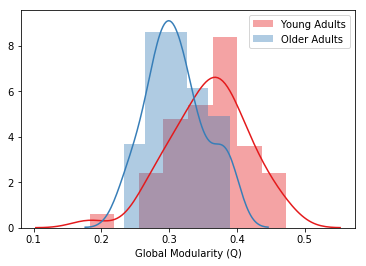

In [309]:
sns.distplot(df[df['Group'] == "Young Adults"]['q_global'].dropna(), label = 'Young Adults')
sns.distplot(df[df['Group'] == "Older Adults"]['q_global'].dropna(), label = 'Older Adults')
plt.xlabel('Global Modularity (Q)')
plt.legend()
plt.savefig(results_dir + 'global_modularity.png', dpi=300)

In [310]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['q_global'].dropna(), df[df['Group'] == "Older Adults"]['q_global'].dropna())

Ttest_indResult(statistic=3.690413675438082, pvalue=0.0004392979352162618)

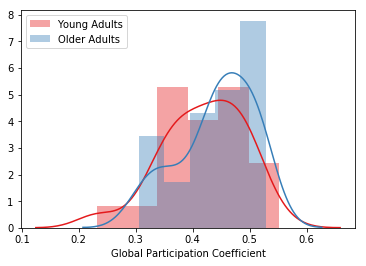

In [352]:
sns.distplot(df[df['Group'] == "Young Adults"]['pc_global'].dropna(), label = 'Young Adults')
sns.distplot(df[df['Group'] == "Older Adults"]['pc_global'].dropna(), label = 'Older Adults')
plt.xlabel('Global Participation Coefficient')
plt.legend()
plt.savefig(results_dir + 'global_pc.png', dpi=300)

In [353]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['pc_global'].dropna(), df[df['Group'] == "Older Adults"]['pc_global'].dropna())

Ttest_indResult(statistic=-1.3802200825266395, pvalue=0.1719109841580321)

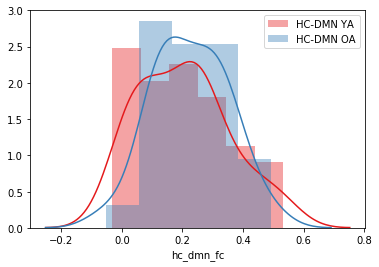

In [311]:
sns.distplot(df[df['Group'] == "Young Adults"]['hc_dmn_fc'], label = 'HC-DMN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['hc_dmn_fc'], label = 'HC-DMN OA')
plt.legend()

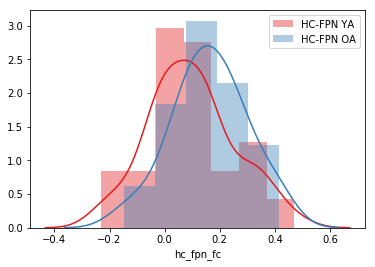

In [312]:
sns.distplot(df[df['Group'] == "Young Adults"]['hc_fpn_fc'], label = 'HC-FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['hc_fpn_fc'], label = 'HC-FPN OA')
plt.legend()

In [313]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['hc_fpn_fc'], df[df['Group'] == "Older Adults"]['hc_fpn_fc'], equal_var=True)

Ttest_indResult(statistic=-1.8805882317569877, pvalue=0.06396288088947184)

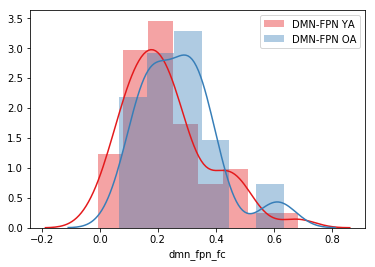

In [314]:
sns.distplot(df[df['Group'] == "Young Adults"]['dmn_fpn_fc'], label = 'DMN-FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['dmn_fpn_fc'], label = 'DMN-FPN OA')
plt.legend()

In [315]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['dmn_fpn_fc'], df[df['Group'] == "Older Adults"]['dmn_fpn_fc'], equal_var=True)

Ttest_indResult(statistic=-1.327256376282923, pvalue=0.18850438620935764)

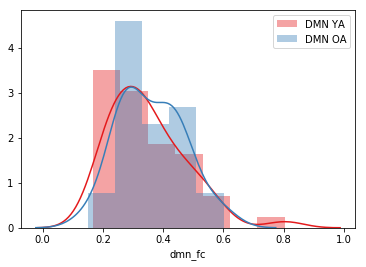

In [316]:
sns.distplot(df[df['Group'] == "Young Adults"]['dmn_fc'], label = 'DMN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['dmn_fc'], label = 'DMN OA')
plt.legend()

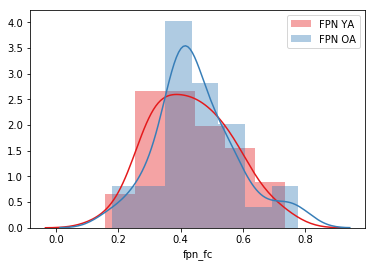

In [317]:
sns.distplot(df[df['Group'] == "Young Adults"]['fpn_fc'], label = 'FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['fpn_fc'], label = 'FPN OA')
plt.legend()

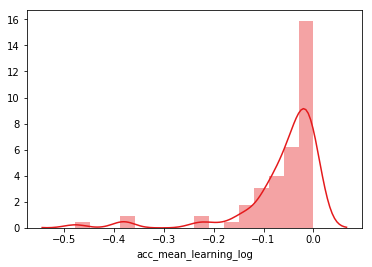

In [319]:
sns.distplot(df['acc_mean_learning_log'].dropna())

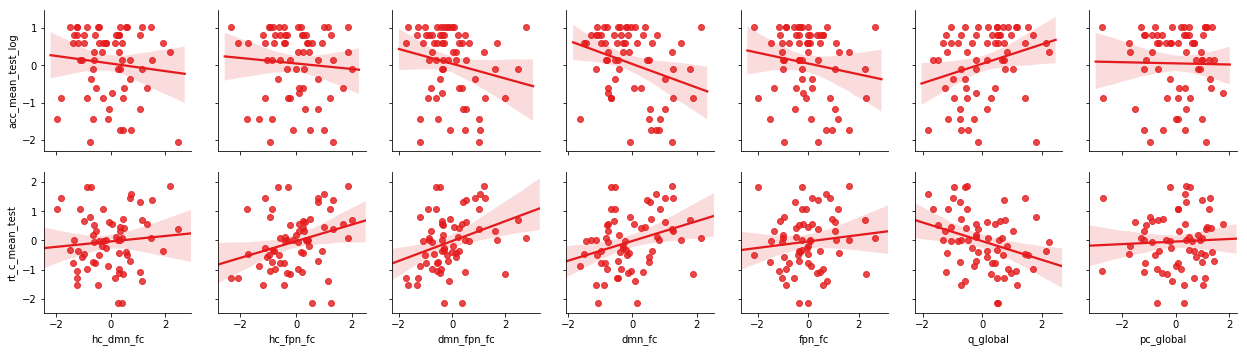

In [355]:
sns.pairplot(regdf[regdf['dmn_fc'] < 3].dropna(), 
             x_vars=['hc_dmn_fc', 'hc_fpn_fc', 'dmn_fpn_fc', 'dmn_fc', 'fpn_fc', 'q_global', 'pc_global'], y_vars=['acc_mean_test_log', 'rt_c_mean_test'],
             palette = 'Set1', kind='reg')

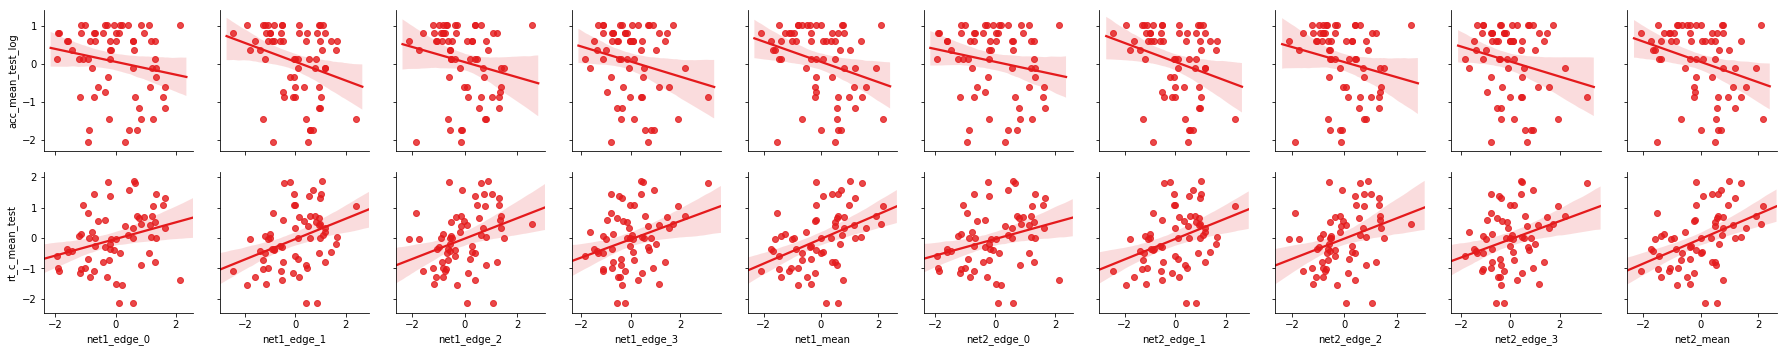

In [356]:
sns.pairplot(regdf[regdf['dmn_fc'] < 3].dropna(), 
             x_vars=edge_cols, y_vars=['acc_mean_test_log', 'rt_c_mean_test'],
             palette = 'Set1', kind='reg')

## Global modularity

In [203]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model1 = smf.ols(formula='acc_mean_test_log ~ q_global + Group', data=regdf[abs(regdf['q_global']) < 3]).fit()

model2 = smf.ols(formula='acc_mean_learning_log ~ q_global + Group', data=regdf[abs(regdf['q_global']) < 3]).fit()

model3 = smf.ols(formula='rt_c_mean_test ~ q_global + Group', data=regdf[abs(regdf['q_global']) < 3]).fit()

model4 = smf.ols(formula='rt_c_mean_learning ~ q_global + Group', data=regdf[abs(regdf['q_global']) < 3]).fit()


In [204]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     6.019
Date:                Tue, 22 Feb 2022   Prob (F-statistic):            0.00390
Time:                        14:25:03   Log-Likelihood:                -96.375
No. Observations:                  72   AIC:                             198.7
Df Residuals:                      69   BIC:                             205.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.0408      0.196     -0.208      0.836      -0.432       0.350
Group[T.Young Adults]     0.0638      0.253      0.253      0.801      -0.440       0.568
q_global                  0.3720      0.121      3.064      0.003       0.130       0.614
==============================================================================
Omnibus:                        8.947   Durbin-Watson:                   2.212
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.844
Skew:                          -0.845   Prob(JB):                       0.0120
Kurtosis:                       3.304   Cond. No.                         3.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [183]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     acc_mean_learning_log   R-squared:                       0.071
Model:                               OLS   Adj. R-squared:                  0.044
Method:                    Least Squares   F-statistic:                     2.638
Date:                   Tue, 22 Feb 2022   Prob (F-statistic):             0.0787
Time:                           14:09:32   Log-Likelihood:                -99.511
No. Observations:                     72   AIC:                             205.0
Df Residuals:                         69   BIC:                             211.9
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0383      0.205      0.187      0.852      -0.370       0.447
Group[T.Young Adults]    -0.0600      0.264     -0.227      0.821      -0.587       0.467
q_global                  0.2768      0.127      2.183      0.032       0.024       0.530
==============================================================================
Omnibus:                       65.601   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              340.779
Skew:                          -2.862   Prob(JB):                     1.00e-74
Kurtosis:                      11.990   Cond. No.                         3.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [205]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_mean_test   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     16.42
Date:                Tue, 22 Feb 2022   Prob (F-statistic):           1.47e-06
Time:                        14:25:16   Log-Likelihood:                -88.152
No. Observations:                  72   AIC:                             182.3
Df Residuals:                      69   BIC:                             189.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5813      0.175      3.325      0.001       0.232       0.930
Group[T.Young Adults]    -0.9099      0.225     -4.035      0.000      -1.360      -0.460
q_global                 -0.2267      0.108     -2.093      0.040      -0.443      -0.011
==============================================================================
Omnibus:                        1.418   Durbin-Watson:                   2.281
Prob(Omnibus):                  0.492   Jarque-Bera (JB):                0.916
Skew:                           0.261   Prob(JB):                        0.633
Kurtosis:                       3.183   Cond. No.                         3.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [206]:
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     rt_c_mean_learning   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     5.143
Date:                Tue, 22 Feb 2022   Prob (F-statistic):            0.00828
Time:                        14:25:19   Log-Likelihood:                -97.161
No. Observations:                  72   AIC:                             200.3
Df Residuals:                      69   BIC:                             207.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.3652      0.198      1.843      0.070      -0.030       0.761
Group[T.Young Adults]    -0.5716      0.256     -2.237      0.029      -1.081      -0.062
q_global                 -0.1473      0.123     -1.200      0.234      -0.392       0.098
==============================================================================
Omnibus:                      111.316   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3258.636
Skew:                           4.846   Prob(JB):                         0.00
Kurtosis:                      34.501   Cond. No.                         3.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## DMN-FPN modularity

In [207]:
model1 = smf.ols(formula='acc_mean_test_log ~ mod_mean + Group', data=regdf[abs(regdf['mod_mean']) < 3]).fit()

model2 = smf.ols(formula='acc_mean_learning_log ~ mod_mean + Group', data=regdf[abs(regdf['mod_mean']) < 3]).fit()

model3 = smf.ols(formula='rt_c_mean_test ~ mod_mean + Group', data=regdf[abs(regdf['mod_mean']) < 3]).fit()

model4 = smf.ols(formula='rt_c_mean_learning ~ mod_mean + Group', data=regdf[abs(regdf['mod_mean']) < 3]).fit()


In [209]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     4.702
Date:                Tue, 22 Feb 2022   Prob (F-statistic):             0.0122
Time:                        14:25:33   Log-Likelihood:                -97.564
No. Observations:                  72   AIC:                             201.1
Df Residuals:                      69   BIC:                             208.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.1308      0.193     -0.679      0.499      -0.515       0.253
Group[T.Young Adults]     0.2047      0.244      0.839      0.405      -0.282       0.692
mod_mean                  0.3067      0.117      2.615      0.011       0.073       0.541
==============================================================================
Omnibus:                       16.181   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.528
Skew:                          -1.146   Prob(JB):                     9.48e-05
Kurtosis:                       3.961   Cond. No.                         3.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Mean FC

In [248]:
model1 = smf.ols(formula='acc_mean_test_log ~ hc_fpn_fc * Group', data=regdf[abs(regdf['dmn_fpn_fc']) < 3]).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     2.541
Date:                Tue, 22 Feb 2022   Prob (F-statistic):             0.0647
Time:                        15:58:23   Log-Likelihood:                -80.954
No. Observations:                  64   AIC:                             169.9
Df Residuals:                      60   BIC:                             178.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.3139      0.188     -1.666      0.101      -0.691       0.063
Group[T.Young Adults]               0.4867      0.240      2.028      0.047       0.007       0.967
hc_fpn_fc                           0.2755      0.188      1.462      0.149      -0.101       0.652
hc_fpn_fc:Group[T.Young Adults]    -0.4747      0.246     -1.928      0.059      -0.967       0.018
==============================================================================
Omnibus:                       10.439   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.938
Skew:                          -1.006   Prob(JB):                      0.00422
Kurtosis:                       3.237   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

β = -0.69, t = -2.72, p = 0.009


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     3.757
Date:                Tue, 22 Feb 2022   Prob (F-statistic):             0.0153
Time:                        15:59:49   Log-Likelihood:                -86.720
No. Observations:                  65   AIC:                             181.4
Df Residuals:                      61   BIC:                             190.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.3139      0.202     -1.555      0.125      -0.718       0.090
Group[T.Young Adults]               0.3626      0.254      1.430      0.158      -0.145       0.870
hc_fpn_fc                           0.2755      0.202      1.365      0.177      -0.128       0.679
hc_fpn_fc:Group[T.Young Adults]    -0.6885      0.254     -2.715      0.009      -1.196      -0.181
==============================================================================
Omnibus:                        8.950   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.985
Skew:                          -0.904   Prob(JB):                       0.0112
Kurtosis:                       3.215   Cond. No.                         3.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Figure size 2400x1800 with 0 Axes>

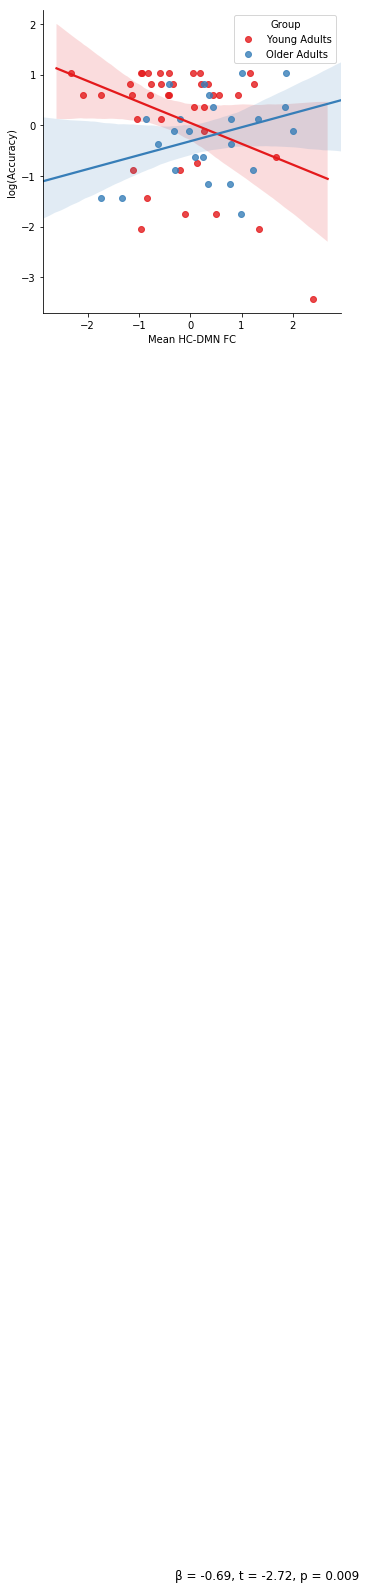

In [249]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'hc_fpn_fc:Group[T.Young Adults]'
plot_title = 'HC-FPN FC'
x_pos = .5
y_pos = -3.4

model = smf.ols(formula='acc_mean_test_log ~ hc_fpn_fc * Group', data=regdf[abs(regdf['hc_fpn_fc']) < 3]).fit()
summary = model.summary()

#df = df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=regdf[abs(regdf['hc_fpn_fc']) < 3], x='hc_fpn_fc', y="acc_mean_test_log", hue='Group', palette = 'Set1', legend_out=False)
plt.ylabel('log(Accuracy)'); plt.xlabel('Mean HC-DMN FC')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

# plt.title('Paracingulate Gyrus - Frontal Orbital Cortex')
plt.savefig(results_dir + 'scatter-hc-dmn-fc_accuracy.png', dpi=300, bbox_inches="tight")

summary

In [210]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# regdf = regdf[regdf['Group'] == "Older Adults"]

model1 = smf.ols(formula='acc_mean_test_log ~ dmn_fpn_fc * Group', data=regdf[abs(regdf['dmn_fpn_fc']) < 3]).fit()

model2= smf.ols(formula='acc_mean_test_log ~ dmn_fc * Group', data=regdf[abs(regdf['dmn_fc']) < 3]).fit()

model3 = smf.ols(formula='acc_mean_test_log ~ fpn_fc * Group', data=regdf[abs(regdf['fpn_fc']) < 3]).fit()


In [211]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     3.914
Date:                Tue, 22 Feb 2022   Prob (F-statistic):             0.0123
Time:                        14:25:51   Log-Likelihood:                -88.732
No. Observations:                  71   AIC:                             185.5
Df Residuals:                      67   BIC:                             194.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.2753      0.176     -1.567      0.122      -0.626       0.075
Group[T.Young Adults]                0.4163      0.220      1.889      0.063      -0.023       0.856
dmn_fpn_fc                           0.1482      0.182      0.816      0.417      -0.214       0.511
dmn_fpn_fc:Group[T.Young Adults]    -0.5182      0.232     -2.230      0.029      -0.982      -0.054
==============================================================================
Omnibus:                       12.459   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.168
Skew:                          -1.013   Prob(JB):                      0.00138
Kurtosis:                       3.586   Cond. No.                         3.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [216]:
smf.ols(formula='acc_mean_test_log ~ dmn_fc + fpn_fc + dmn_fpn_fc * Group', data=regdf[abs(regdf['dmn_fpn_fc']) < 3]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     4.126
Date:                Tue, 22 Feb 2022   Prob (F-statistic):            0.00258
Time:                        14:27:07   Log-Likelihood:                -84.680
No. Observations:                  71   AIC:                             181.4
Df Residuals:                      65   BIC:                             194.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.3561      0.172     -2.073      0.042      -0.699      -0.013
Group[T.Young Adults]                0.5191      0.216      2.404      0.019       0.088       0.950
dmn_fc                              -0.6433      0.233     -2.765      0.007      -1.108      -0.179
fpn_fc                              -0.0489      0.158     -0.309      0.758      -0.365       0.267
dmn_fpn_fc                           0.7746      0.304      2.551      0.013       0.168       1.381
dmn_fpn_fc:Group[T.Young Adults]    -0.5747      0.225     -2.555      0.013      -1.024      -0.125
==============================================================================
Omnibus:                        3.950   Durbin-Watson:                   1.737
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                3.696
Skew:                          -0.557   Prob(JB):                        0.158
Kurtosis:                       2.916   Cond. No.                         6.28
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [217]:
smf.ols(formula='acc_mean_test_log ~ dmn_fpn_fc + fpn_fc + dmn_fc * Group', data=regdf[abs(regdf['dmn_fc']) < 3]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     4.342
Date:                Tue, 22 Feb 2022   Prob (F-statistic):            0.00180
Time:                        14:27:14   Log-Likelihood:                -84.234
No. Observations:                  71   AIC:                             180.5
Df Residuals:                      65   BIC:                             194.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.2976      0.167     -1.778      0.080      -0.632       0.037
Group[T.Young Adults]            0.4662      0.214      2.182      0.033       0.039       0.893
dmn_fpn_fc                       0.3303      0.253      1.307      0.196      -0.174       0.835
fpn_fc                          -0.0340      0.157     -0.217      0.829      -0.347       0.279
dmn_fc                          -0.1832      0.277     -0.662      0.511      -0.736       0.370
dmn_fc:Group[T.Young Adults]    -0.6195      0.227     -2.726      0.008      -1.073      -0.166
==============================================================================
Omnibus:                        3.756   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.153   Jarque-Bera (JB):                3.649
Skew:                          -0.508   Prob(JB):                        0.161
Kurtosis:                       2.551   Cond. No.                         5.86
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

β = -0.64, t = -2.82, p = 0.006


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     6.622
Date:                Tue, 22 Feb 2022   Prob (F-statistic):           0.000552
Time:                        14:27:25   Log-Likelihood:                -85.247
No. Observations:                  71   AIC:                             178.5
Df Residuals:                      67   BIC:                             187.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.2500      0.163     -1.532      0.130      -0.576       0.076
Group[T.Young Adults]            0.3911      0.206      1.903      0.061      -0.019       0.801
dmn_fc                           0.0982      0.176      0.558      0.579      -0.253       0.450
dmn_fc:Group[T.Young Adults]    -0.6371      0.226     -2.820      0.006      -1.088      -0.186
==============================================================================
Omnibus:                        5.385   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                5.347
Skew:                          -0.667   Prob(JB):                       0.0690
Kurtosis:                       2.830   Cond. No.                         3.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Figure size 2400x1800 with 0 Axes>

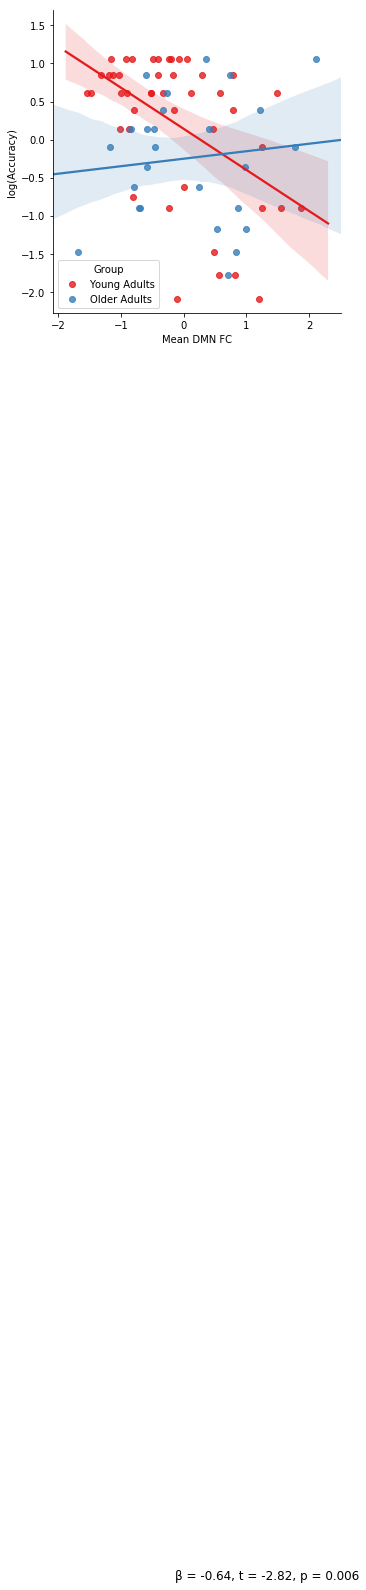

In [218]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'dmn_fc:Group[T.Young Adults]'
plot_title = 'DMN FC'
x_pos = .5
y_pos = -3.4

model = smf.ols(formula='acc_mean_test_log ~ dmn_fc * Group', data=regdf[abs(regdf['dmn_fc']) < 3]).fit()
summary = model.summary()

#df = df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=regdf[abs(regdf['dmn_fc']) < 3], x='dmn_fc', y="acc_mean_test_log", hue='Group', palette = 'Set1', legend_out=False)
plt.ylabel('log(Accuracy)'); plt.xlabel('Mean DMN FC')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

# plt.title('Paracingulate Gyrus - Frontal Orbital Cortex')
plt.savefig(results_dir + 'scatter-dmn-fc_accuracy.png', dpi=300, bbox_inches="tight")

summary

In [229]:
smf.ols(formula='acc_mean_test_log ~ dmn_fpn_fc + fpn_fc + dmn_fc', data=regdf[(abs(regdf['dmn_fc']) < 3) & (regdf['Group'] == 'Young Adults')]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     5.130
Date:                Tue, 22 Feb 2022   Prob (F-statistic):            0.00418
Time:                        14:32:40   Log-Likelihood:                -53.691
No. Observations:                  45   AIC:                             115.4
Df Residuals:                      41   BIC:                             122.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1608      0.129      1.251      0.218      -0.099       0.421
dmn_fpn_fc     0.2420      0.291      0.832      0.410      -0.345       0.829
fpn_fc         0.0525      0.193      0.273      0.787      -0.336       0.441
dmn_fc        -0.7857      0.272     -2.889      0.006      -1.335      -0.237
==============================================================================
Omnibus:                        4.051   Durbin-Watson:                   1.522
Prob(Omnibus):                  0.132   Jarque-Bera (JB):                3.797
Skew:                          -0.699   Prob(JB):                        0.150
Kurtosis:                       2.735   Cond. No.                         4.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [228]:
smf.ols(formula='acc_mean_test_log ~ dmn_fpn_fc + fpn_fc + dmn_fc', data=regdf[(abs(regdf['dmn_fc']) < 3) & (regdf['Group'] == 'Older Adults')]).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      acc_mean_test_log   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                 -0.052
Method:                 Least Squares   F-statistic:                    0.5855
Date:                Tue, 22 Feb 2022   Prob (F-statistic):              0.631
Time:                        14:32:29   Log-Likelihood:                -30.091
No. Observations:                  26   AIC:                             68.18
Df Residuals:                      22   BIC:                             73.22
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3408      0.182     -1.872      0.074      -0.718       0.037
dmn_fpn_fc     0.6280      0.532      1.182      0.250      -0.474       1.730
fpn_fc        -0.2348      0.283     -0.829      0.416      -0.822       0.352
dmn_fc        -0.2932      0.459     -0.638      0.530      -1.246       0.660
==============================================================================
Omnibus:                        0.340   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.844   Jarque-Bera (JB):                0.498
Skew:                          -0.191   Prob(JB):                        0.780
Kurtosis:                       2.440   Cond. No.                         6.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

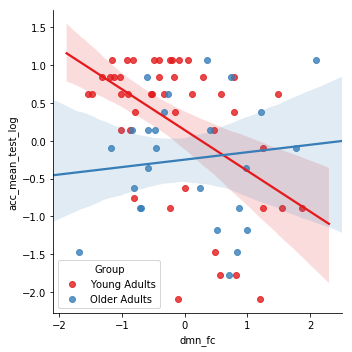

In [155]:
sns.lmplot(data=regdf, x='dmn_fc', y="acc_mean_test_log", hue='Group', palette = 'Set1', legend_out=False)

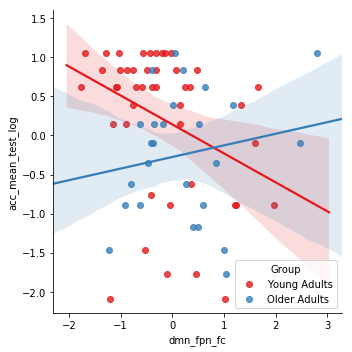

In [156]:
sns.lmplot(data=regdf, x='dmn_fpn_fc', y="acc_mean_test_log", hue='Group', palette = 'Set1', legend_out=False)

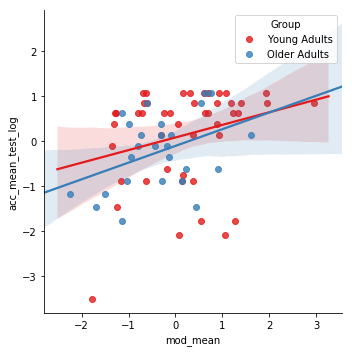

In [191]:
sns.lmplot(data=regdf, x='mod_mean', y="acc_mean_test_log", hue='Group', palette = 'Set1', legend_out=False)

## RAR

In [342]:
smf.ols(formula='q_global ~ actamp', data=regdf[(abs(regdf['q_global']) < 3) & (abs(regdf['actamp']) < 3)]).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               q_global   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     8.573
Date:                Tue, 22 Feb 2022   Prob (F-statistic):            0.00474
Time:                        16:48:00   Log-Likelihood:                -88.085
No. Observations:                  65   AIC:                             180.2
Df Residuals:                      63   BIC:                             184.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.847e-17      0.118   7.48e-16      1.000      -0.236       0.236
actamp         0.3461      0.118      2.928      0.005       0.110       0.582
==============================================================================
Omnibus:                        1.585   Durbin-Watson:                   1.580
Prob(Omnibus):                  0.453   Jarque-Bera (JB):                1.385
Skew:                           0.205   Prob(JB):                        0.500
Kurtosis:                       2.414   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [343]:
smf.ols(formula='q_global ~ actphi', data=regdf[(abs(regdf['q_global']) < 3) & (abs(regdf['actphi']) < 3)]).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               q_global   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.292
Date:                Tue, 22 Feb 2022   Prob (F-statistic):              0.135
Time:                        16:48:35   Log-Likelihood:                -91.070
No. Observations:                  65   AIC:                             186.1
Df Residuals:                      63   BIC:                             190.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.847e-17      0.124   7.15e-16      1.000      -0.247       0.247
actphi         0.1873      0.124      1.514      0.135      -0.060       0.435
==============================================================================
Omnibus:                        0.199   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.905   Jarque-Bera (JB):                0.095
Skew:                          -0.091   Prob(JB):                        0.953
Kurtosis:                       2.958   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [240]:
smf.ols(formula='fpn_fc ~ actamp', data=regdf[(abs(regdf['dmn_fc']) < 3) & (abs(regdf['actamp']) < 3)]).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 fpn_fc   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     3.752
Date:                Tue, 22 Feb 2022   Prob (F-statistic):             0.0573
Time:                        15:41:41   Log-Likelihood:                -87.281
No. Observations:                  64   AIC:                             178.6
Df Residuals:                      62   BIC:                             182.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0397      0.120     -0.330      0.742      -0.280       0.201
actamp         0.2394      0.124      1.937      0.057      -0.008       0.487
==============================================================================
Omnibus:                        3.017   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.221   Jarque-Bera (JB):                2.489
Skew:                           0.481   Prob(JB):                        0.288
Kurtosis:                       3.082   Cond. No.                         1.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [243]:
smf.ols(formula='dmn_fpn_fc ~ actphi', data=regdf[(abs(regdf['dmn_fc']) < 3) & (abs(regdf['actphi']) < 3)]).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             dmn_fpn_fc   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                   0.06692
Date:                Tue, 22 Feb 2022   Prob (F-statistic):              0.797
Time:                        15:42:08   Log-Likelihood:                -85.974
No. Observations:                  64   AIC:                             175.9
Df Residuals:                      62   BIC:                             180.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0493      0.118     -0.419      0.677      -0.285       0.186
actphi        -0.0305      0.118     -0.259      0.797      -0.266       0.205
==============================================================================
Omnibus:                        9.655   Durbin-Watson:                   1.737
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.269
Skew:                           0.855   Prob(JB):                      0.00971
Kurtosis:                       3.742   Cond. No.                         1.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [340]:
smf.ols(formula='net1_mean ~ actphi * Group', data=regdf[abs(regdf['net1_mean']) < 3]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              net1_mean   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     9.569
Date:                Tue, 22 Feb 2022   Prob (F-statistic):           2.87e-05
Time:                        16:44:28   Log-Likelihood:                -79.696
No. Observations:                  65   AIC:                             167.4
Df Residuals:                      61   BIC:                             176.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.7395      0.232      3.190      0.002       0.276       1.203
Group[T.Young Adults]           -1.2470      0.276     -4.523      0.000      -1.798      -0.696
actphi                           0.0576      0.229      0.251      0.802      -0.400       0.515
actphi:Group[T.Young Adults]     0.1055      0.274      0.385      0.702      -0.442       0.653
==============================================================================
Omnibus:                        0.190   Durbin-Watson:                   1.340
Prob(Omnibus):                  0.909   Jarque-Bera (JB):                0.386
Skew:                           0.045   Prob(JB):                        0.825
Kurtosis:                       2.634   Cond. No.                         5.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""